1. Najlepsza opcja - non python 

In [ ]:
#gdalwarp -rpc -t_srs EPSG:32633 "data/21AUG09094021-M1BS-017181470010_01_P002.TIF" "output/output_ortho.tif"


In [ ]:
2. Próba z ulepszonym parserem

In [ ]:
from inverse_rpc import ortho_rpc_grid

ortho_rpc_grid(
    tif_path="data/21AUG09094021-M1BS-017181470010_01_P002.TIF",
    rpb_path="data/21AUG09094021-M1BS-017181470010_01_P002.RPB",
    dst_crs="EPSG:32633",
    spacing=50
)


In [ ]:
3. Próba z pierwszym parserem 

In [5]:
import numpy as np
import rasterio
from rasterio.transform import from_origin
from pyproj import Transformer
import matplotlib.pyplot as plt
from rpc_model import RPCModel  # zakładamy, że masz już rpc_model.py obok

# === Ścieżki ===
tif_path = "data/21AUG09094021-M1BS-017181470010_01_P002.TIF"
rpb_path = "data/21AUG09094021-M1BS-017181470010_01_P002.RPB"


In [13]:
# === Wczytaj RPC ===
rpc = RPCModel.from_rpb(rpb_path)

# === Wczytaj obraz ===
with rasterio.open(tif_path) as src:
    img = src.read()  # (bands, height, width)
    print(f"Rozmiar: {src.width} x {src.height}, kanały: {src.count}")

# === Przybliżona lokalizacja (środek sceny z RPC) ===
h = 30.0  # przyjęta wysokość terenu
lat0 = 51.4060
lon0 = 21.2460

print(f"Przybliżony środek sceny: {lat0:.6f} N, {lon0:.6f} E")

Rozmiar: 9376 x 2256, kanały: 4
Przybliżony środek sceny: 51.406000 N, 21.246000 E


Zapisano plik: output_approx.tif


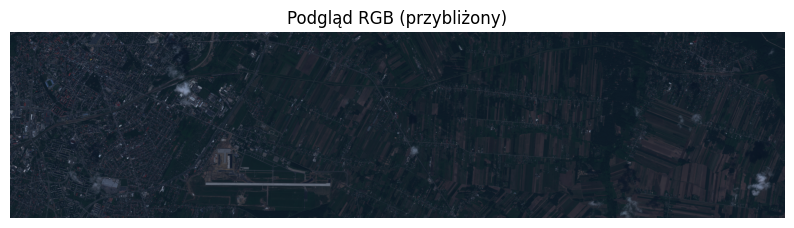

In [16]:
# === Przekształć lat/lon na UTM (np. EPSG:32633) ===
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32633", always_xy=True)
x0, y0 = transformer.transform(lon0, lat0)

# === Ustal geotransformację (przybliżenie) ===
pixel_size = 1  # arbitralnie 1m, bo brak odwrotnego RPC
transform = from_origin(x0, y0, pixel_size, pixel_size)

# === Przygotuj metadane do zapisu ===
meta = {
    'driver': 'GTiff',
    'height': img.shape[1],
    'width': img.shape[2],
    'count': img.shape[0],
    'dtype': img.dtype,
    'crs': 'EPSG:32633',
    'transform': transform
}

# === Zapis GeoTIFF z przybliżonym położeniem ===
with rasterio.open("output_approx.tif", 'w', **meta) as dst:
    for i in range(img.shape[0]):
        dst.write(img[i], i+1)

print("Zapisano plik: output_approx.tif")

# === Wizualizacja RGB lub grayscale ===
if img.shape[0] >= 3:
    rgb = np.stack([img[2], img[1], img[0]], axis=-1)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.clip(rgb / 2048, 0, 1))
    plt.title("Podgląd RGB (przybliżony)")
    plt.axis('off')
    plt.show()
else:
    plt.imshow(img[0], cmap='gray')
    plt.title("Podgląd (mono)")
    plt.axis('off')
    plt.show()


CE90 = 4.24 jednostek


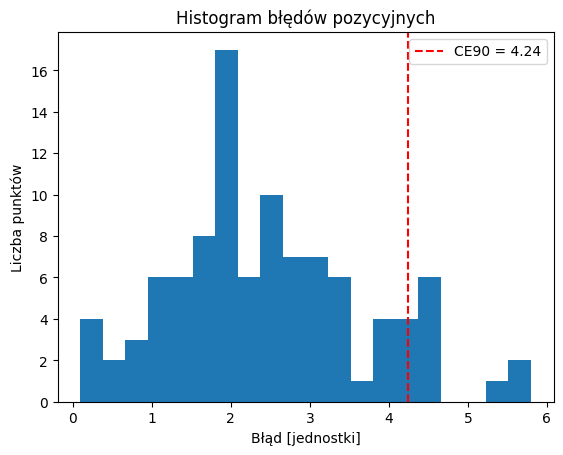

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Przykład danych (można zastąpić rzeczywistymi):
np.random.seed(0)
df_ref = pd.DataFrame({'X': np.random.uniform(1000, 2000, 100), 'Y': np.random.uniform(1000, 2000, 100)})
df_test = df_ref.copy()
df_test['X'] += np.random.normal(0, 2, 100)  # symulacja błędów
df_test['Y'] += np.random.normal(0, 2, 100)

# Oblicz różnice
dx = df_test['X'] - df_ref['X']
dy = df_test['Y'] - df_ref['Y']
d = np.sqrt(dx**2 + dy**2)

# CE90
ce90 = np.percentile(d, 90)
print(f'CE90 = {ce90:.2f} jednostek')

# Histogram błędów
plt.hist(d, bins=20)
plt.axvline(ce90, color='red', linestyle='--', label=f'CE90 = {ce90:.2f}')
plt.title('Histogram błędów pozycyjnych')
plt.xlabel('Błąd [jednostki]')
plt.ylabel('Liczba punktów')
plt.legend()
plt.show()
